In [40]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
%matplotlib inline
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use("fivethirtyeight")

In [2]:
listings = pd.read_csv("data/listings.csv")
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20191121092222,2019-11-21,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,This charming two bedroom beachfront condomini...,Missionbeachretreat. Great Ocean Front Condo...,none,While some may compare San Diego’s Mission Bea...,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
1,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace- SD's Best Hood!,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,none,South Park is a charming community and our nei...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.36
2,29967,https://www.airbnb.com/rooms/29967,20191121092222,2019-11-21,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...","This two bedroom (1 CA king bed, 1 queen bed),...","This 2 bedroom, 2 full bathroom home offers al...",none,NaN,...,f,f,moderate,f,f,5,5,0,0,0.53
3,38245,https://www.airbnb.com/rooms/38245,20191121092222,2019-11-21,Point Loma/Liberty Station-NTC,Stay in a 1928 Spanish Style home. Den is dow...,Please note: 1928 home; remodeled in 2015. Co...,Stay in a 1928 Spanish Style home. Den is dow...,none,"This neighborhood is an expensive, high-end Po...",...,f,f,moderate,t,t,3,0,3,0,1.28
4,39516,https://www.airbnb.com/rooms/39516,20191121092222,2019-11-21,Art Studio Retreat/Rustic Cabin,We love having explorers from all over the wor...,"Nestled in South/North Park, a gentrified neig...",We love having explorers from all over the wor...,none,"We love our eclectic neighborhood, with a smal...",...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,3.38


In [3]:
calendar = pd.read_csv("data/calendar.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
parse_price = lambda p: float(p.replace(",", "")[1:])
calendar["price"] = calendar["price"].apply(parse_price)
calendar["adjusted_price"] = calendar["adjusted_price"].apply(parse_price)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5570,2019-11-21,f,2050.0,2050.0,3,365
1,5570,2019-11-22,f,2050.0,2050.0,3,365
2,5570,2019-11-23,f,2050.0,2050.0,3,365
3,5570,2019-11-24,f,2050.0,2050.0,3,365
4,5570,2019-11-25,f,2050.0,2050.0,3,365


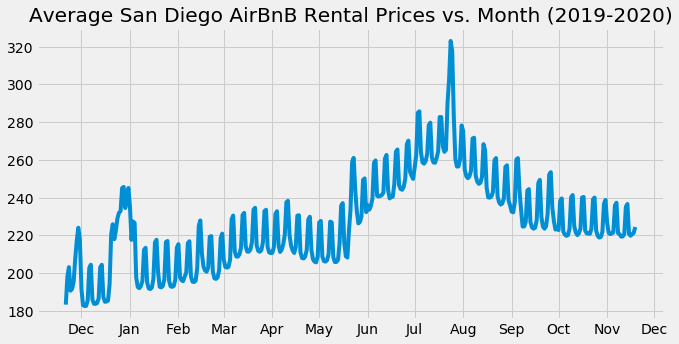

In [4]:
fig = plt.figure(figsize=(10, 5))
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(months_fmt)
plt.title("Average San Diego AirBnB Rental Prices vs. Month (2019-2020)")

# Create and plot time series
avg_prices = calendar.groupby("date").mean()["price"]
plt.plot(avg_prices.index, avg_prices)
plt.savefig("plots/averagePrice.png")

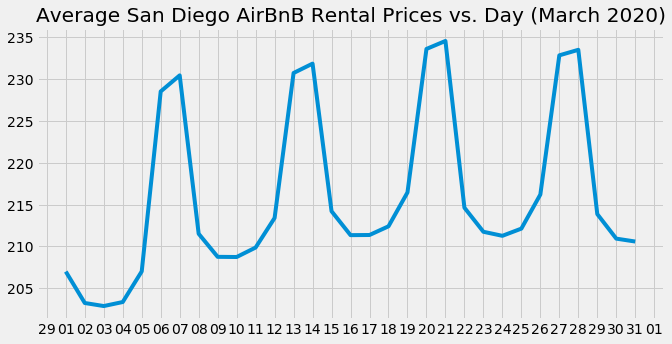

In [6]:
fig = plt.figure(figsize=(10, 5))
days = mdates.DayLocator()
days_fmt = mdates.DateFormatter('%d')
plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(days_fmt)
avg_prices = calendar.groupby("date").mean()["price"]
plt.title("Average San Diego AirBnB Rental Prices vs. Day (March 2020)")

# Create and plot time series of prices in march
march_prices = avg_prices[avg_prices.index.month == 3]
plt.plot(march_prices.index, march_prices);

plt.savefig("plots/averagePrice.png")

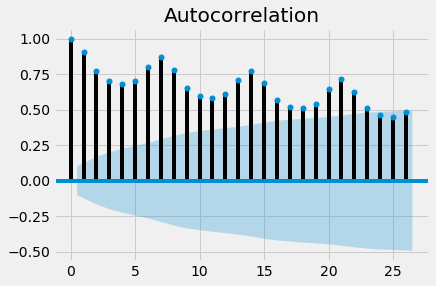

In [7]:
plot_acf(avg_prices);

In [10]:
def is_stationary(ser, maxlag=9, autolag=None, regression='ct'): 
    """Test if series is stationary using Augmented Dickey Fuller test""" 

    adf_test = adfuller(ser,maxlag=maxlag, autolag=autolag, regression=regression) 
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]

    result = adf < cv_5    
    return result

In [11]:
is_stationary(avg_prices)

False

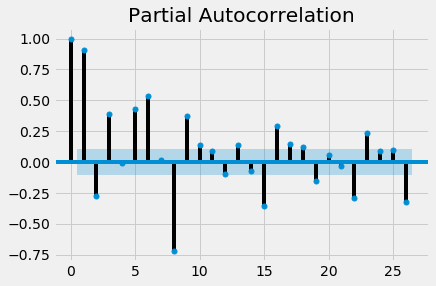

In [12]:
plot_pacf(avg_prices.iloc[:]);

In [13]:
deltas = avg_prices.index - pd.DatetimeIndex([datetime.date(2020, 10, 1) for x in range(len(avg_prices))])
train_part = avg_prices[deltas.days < 0]
test_part = avg_prices[~(deltas.days < 0)]

In [14]:
train_part.tail()

date
2020-09-26    253.467217
2020-09-27    234.605127
2020-09-28    227.417047
2020-09-29    223.048475
2020-09-30    223.340725
Name: price, dtype: float64

In [15]:
test_part.head()

date
2020-10-01    222.791513
2020-10-02    238.229704
2020-10-03    239.538898
2020-10-04    222.023206
2020-10-05    220.352659
Name: price, dtype: float64

In [32]:
# Function to calculate rmse using residual values
calculate_rmse = lambda res: np.sqrt((res ** 2).sum()/(len(res)))

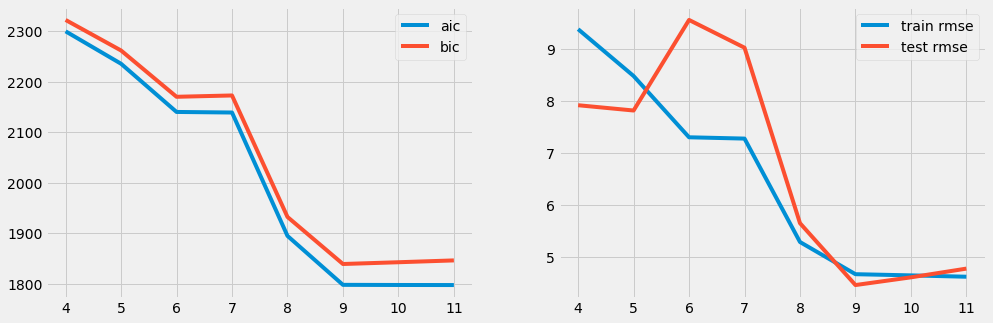

In [41]:
# Search to find optimal Autoregression order
ar_search = pd.DataFrame(columns=["aic", "bic", "train rmse", "test rmse"])
for i in range(4, 12):
    # Fit AR model
    ar_model = ARIMA(train_part, order=(i, 0, 0))
    ar_res = ar_model.fit()
    
    # Calculate metrics
    train_rmse = calculate_rmse(ar_res.resid)
    test_preds = ar_res.forecast(len(test_part))[0]
    test_rmse =  calculate_rmse(test_preds - test_part)
    
    # Add metrics to dataframe
    ar_search.loc[i] = (ar_res.aic, ar_res.bic, train_rmse, test_rmse)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ar_search.plot(y=["aic", "bic"], ax=ax1)
ar_search.plot(y=["train rmse", "test rmse"], ax=ax2);

In [42]:
# AR model with optimal order from search
ar_model = ARIMA(train_part, order=(9, 0, 0))
ar_res = ar_model.fit()

In [19]:
# Define parameter search space and dataframe to store metrics
grid_search = pd.DataFrame(columns=["d", "q", "aic", "bic", "train rmse", "test rmse"])
diff_search_space = [0, 2]
ma_search_space = list(range(7))
search_space = [(9, d, q) for d in diff_search_space for q in ma_search_space]
for i, params in enumerate(search_space):
    # Fit ARIMA model
    arima_model = ARIMA(train_part, order=params)
    arima_res = arima_model.fit()
    
    # Calculate metrics
    train_rmse = calculate_rmse(arima_res.resid)
    test_preds = arima_res.forecast(len(test_part))[0]
    test_rmse =  calculate_rmse(test_preds - test_part)
    
    # Add metrics to dataframe
    grid_search.loc[i] = (params[1], params[2], arima_res.aic, arima_res.bic, train_rmse, test_rmse)

C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tanve\

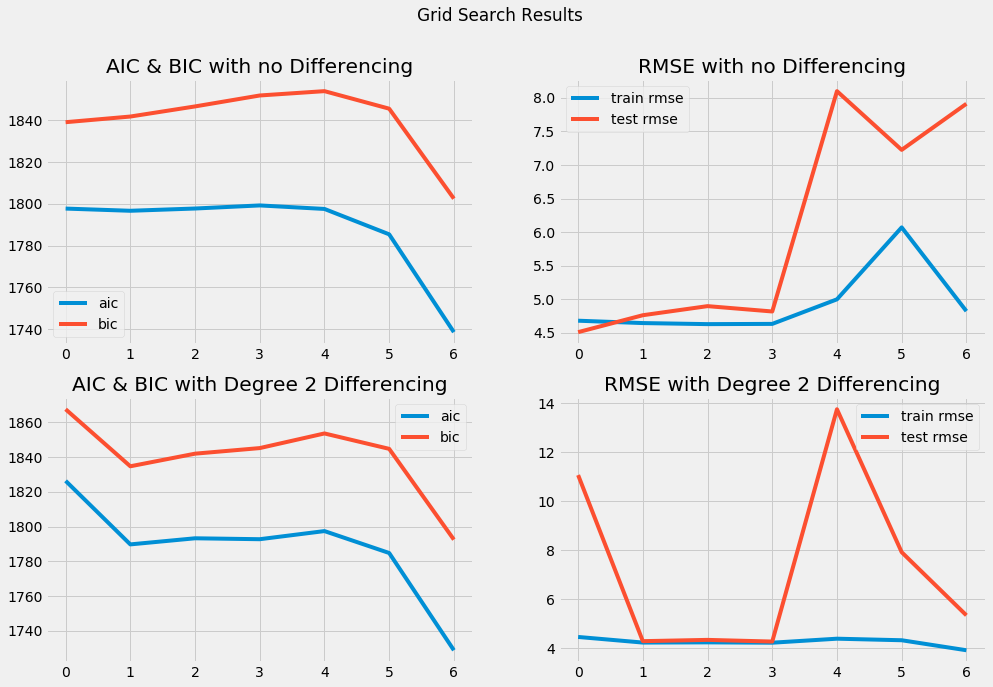

In [20]:
diff0 = grid_search.groupby("d").get_group(0).reset_index(drop=True)
diff2 = grid_search.groupby("d").get_group(2).reset_index(drop=True)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Grid Search Results")
axes[0, 0].title.set_text("AIC & BIC with no Differencing")
axes[0, 1].title.set_text("RMSE with no Differencing")
axes[1, 0].title.set_text("AIC & BIC with Degree 2 Differencing")
axes[1, 1].title.set_text("RMSE with Degree 2 Differencing")
diff0.plot(y=["aic", "bic"], ax=axes[0, 0])
diff0.plot(y=["train rmse", "test rmse"], ax=axes[0, 1])
diff2.plot(y=["aic", "bic"], ax=axes[1, 0])
diff2.plot(y=["train rmse", "test rmse"], ax=axes[1, 1]);

In [21]:
indices = grid_search.drop(["d", "q"], axis=1).idxmin()
grid_search[["d", "q"]].iloc[indices].set_index(indices.index)

,d,q
aic,2.0,6.0
bic,2.0,6.0
train rmse,2.0,6.0
test rmse,2.0,3.0


In [23]:
# Best hyperparameters from grid search
arima_model = ARIMA(train_part, order=(9, 2, 6))
arima_res = arima_model.fit()

C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [56]:
# Save model parameters to disk
pickle.dump(ar_res.params, open(os.path.join("models", "AR_params.pkl"), "wb+"))
pickle.dump(arima_res.params, open(os.path.join("models", "ARIMA_params.pkl"), "wb+"))

In [34]:
# Modeling evaluation
print("AR Training RMSE:", calculate_rmse(ar_res.resid))
print("AR Out of Sample Testing RMSE:", calculate_rmse(ar_res.forecast(len(test_part))[0] - test_part))
print("ARIMA Training RMSE:", calculate_rmse(arima_res.resid))
print("ARIMA Out of Sample Testing RMSE:", calculate_rmse(arima_res.forecast(len(test_part))[0] - test_part))

AR Training RMSE: 4.673898710485799
AR Testing RMSE: 4.465872868722263
ARIMA Training RMSE: 3.9141778317839093
ARIMA Testing RMSE: 5.291150234840783


ARIMA Testing RMSE: 5.053896689871007


AttributeError: module 'matplotlib.pyplot' has no attribute 'yaxis'

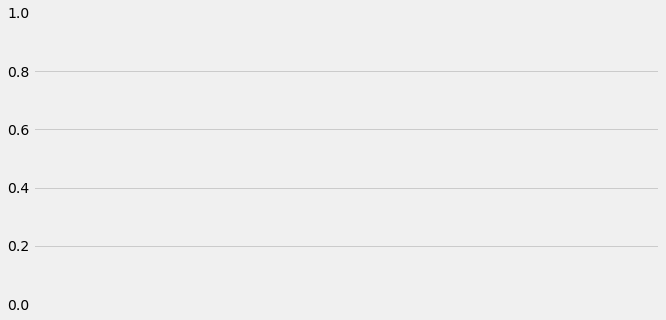

In [57]:
# Series to store model predictions
predictions = test_part.copy() * 0
# Series with last 60 days of prices
history = train_part.copy().iloc[-60:]
for date in test_part.index:
    # Fit model on updated data
    model = ARIMA(history, order=(9, 2, 6))
    model_res = model.fit(arima_res.params)
    # Make new forecast
    yhat = model_res.forecast()[0]
    predictions.loc[date] = yhat
    history.loc[date] = test_part[date]

# Calculate RMSE
error = mean_squared_error(test_part, predictions)
print("ARIMA Testing RMSE:", error)

# Plot predicted vs. actual price
fig, ax = plt.subplots(figsize=(10, 5))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.yaxis("Price($)")
plt.title("Test Set Predictions")
plt.plot(predictions)
plt.plot(test_part)
plt.legend(["forecast", "price"]);

In [30]:

np.sqrt(mean_squared_error(test_part, predictions))

1.9261377808594333

AttributeError: module 'matplotlib.pyplot' has no attribute 'y_axis'

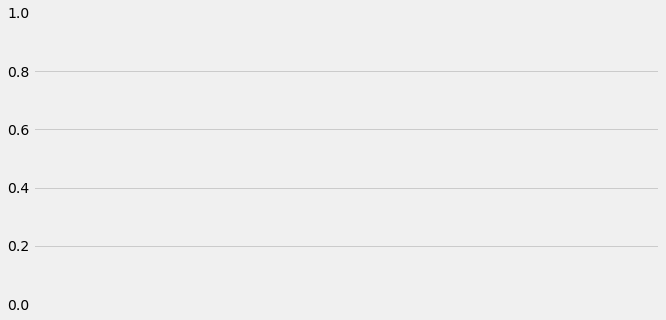

In [58]:
# Plot predicted vs. actual price
fig, ax = plt.subplots(figsize=(10, 5))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.y_axis("Price($)")
plt.title("Test Set Predictions")
plt.plot(predictions)
plt.plot(test_part)
plt.legend(["forecast", "price"]);

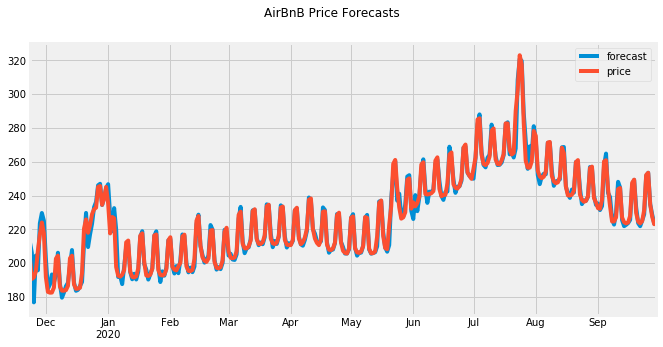

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("AirBnB Price Forecasts")
arima_res.plot_predict(ax=ax);

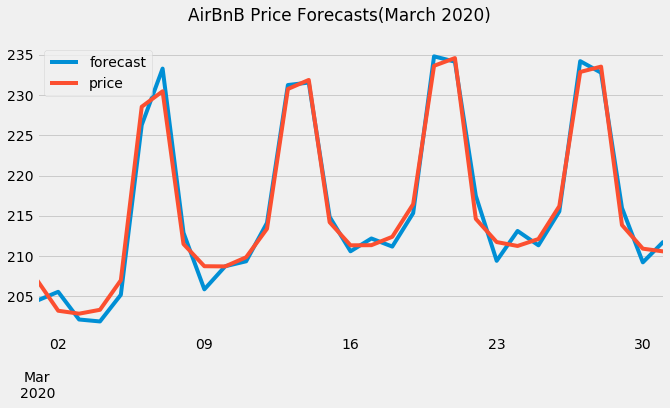

In [137]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("AirBnB Price Forecasts(March 2020)")
arima_res.plot_predict(march_prices.index[0], march_prices.index[-1], ax=ax);

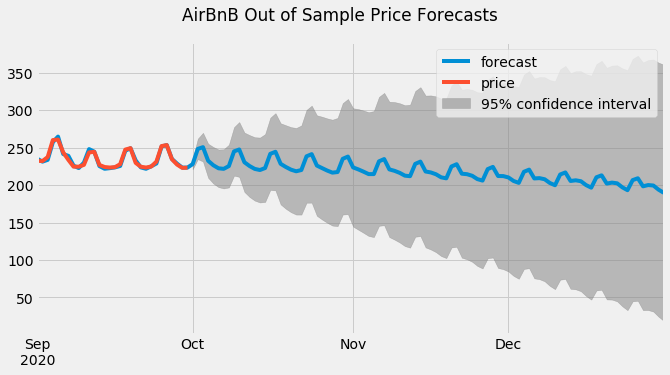

In [153]:
fig, ax = plt.subplots(figsize=(10, 5))
subset = avg_prices[avg_prices.index.date >= datetime.date(2020, 9, 1)]

fig.suptitle("AirBnB Out of Sample Price Forecasts")
arima_res.plot_predict(datetime.date(2020, 9, 1), datetime.date(2020, 12, 31), ax=ax);
ax.plot(subset.index, subset, c='r');